# ICON 2017 Multivoxel pattern analysis workshop
Welcome to this workshop!

###### 1. Goals
In this workshop, we cover the basics of applying multivoxel pattern analysis (MVPA) to analyze (functional) MRI data. After this tutorial, you will understand:

- The differences between within-subject and between-subject pattern analysis
- Extracting patterns from fMRI data
- Methods for feature extraction and selection
- Model selection and evaluation

In short, this tutorial will show how to build your own complete, cross-validated pipeline to perform MVPA.

###### 2. Pre-requisites
For this tutorial, we assume that you are familiar with analyzing (f)MRI data and want to know how you would go about implementing a machine-learning (“decoding”) analysis in Python. As such, it’s definitely helpful if you have some knowledge about Python’s syntax, but it’s not strictly necessary. Also, we assume participants are relatively unfamiliar with machine learning (ML) concepts and their implementation; if you’re a ML guru, this is probably not the right workshop for you.

###### 3. Scope and content
There is actually no single "multivoxel pattern analysis", rather, MVPA is a bucket-term referring to several kinds of analyses. As this tutorial cannot cover all such analyses, we limit the scope to *within-subject* designs and *classification* analyses. We hope to cover these grounds sufficiently well for you to be able to explore other kinds of analyses own your own. Inspired by this workshop and want more? Definitely try to implement between-subject designs and regression!

The tutorial is split in two parts. In the first part, we cover the basics of experimental designs, and illustrate how to extract patterns from raw fMRI data in a way that MVPA can be applied. In the second part, MVPA proper is discussed: feature extraction and selection, and model selection and evaluation. We challenge you to optimize your pipelines to maximize your decoding accuracy scores.

Have fun and good luck!

##### 4. In case you have not yet downloaded the data used in this workshop
Foei! Do it now

## Part 1: Experimental design and loading data

### 1.1 Designs for pattern analysis
There are many ways in which you can categorize different types of pattern analyses, but one of the most basic categorizations is in terms of whether analyses are **within-subject** or **between-subject**. The major distinction revolves around whether you want to investigate an (experimental) factor that varies or is manipulated within subjects or that varies across subjects (i.e. individual differences or experimental between-subject designs).

Importantly, these types of analyses differ in what is regarded as an *instance of a pattern*:
- in within-subject analyses, *each instance of your feature-of-interest represents one pattern* (e.g., each single trial);
- in between-subject analyses, *each subject represents one pattern*.

This distinction is important, because the choice of type of pattern analysis has major consequences for the design of your experiment, and the methods available for pattern extraction. **Throughout this tutorial, we focus on within-subject analyses.** We will extract *patterns* of $\beta$-estimates by fitting a hemodynamic response function (HRF) per trial using a general linear model (GLM). There are other methods available of pattern extraction; but this method is known to yeild the most stable pattern estimates and is therefore used most often.

### 1.2. Within-subject designs
Often, "trials" (i.e. instances of your feature-of-interest) in within-subject designs are modelled as separate regressors in a first-level analysis. In other words, you model each trial as a separate (*single!*) HRF-response. Below, we included an image of a single-trial design (of the hypothetical faces vs. houses experiment) as created in FSL:<img src="single_trial_design.png" alt="Drawing" heigth="100" width="400">

As you can see, each trial gets it's own regressor (hence the name single-trial design). Then, as depicted below the design matrix, a contrast-against-baseline is created for each regressor (trial). After you run a first-level analysis using this design, you'll have whole-brain maps containing statistics values ($\beta$-values, *t*-values, or *z*-values) for each trial that represent the trial's estimated (whole-brain) pattern. Usually, *t*-values or *z*-values are used instead of $\beta$-values.  

**Importantly, this design thus specifies that each "trial" represents a sample with its own pattern (voxels).**

Before you go on, make sure you understand this image! This image represents basically all you need to understand about single-trial designs. 

#### Implement your own single-trial design
To further illustrate how single-trial designs work, let's create your own single-trial matrix corresponding to a (real) working memory experiment. In this experiment, one condition ("ACTIVE") required subjects to remember a configuration of bars, and after a retention period had to respond whether one of the bars has changed in the test-image or not. In the other condition ("PASSIVE") they just watched a blank screen and had to respond with a random answer. The experiment is depicted schematically below:

![test](WM_example.png) 

In total, subjects performed 40 trials, of which 32 were of the "ACTIVE" condition and 8 were of the "PASSIVE" condition. In the following section, we'll generate a single-trial design that aims to estimate the pattern for each trial.

Below, we'll load the trial onset times (and trial durations and conditions).

In [1]:
# First, we need to import some Python packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

In [2]:
# The onset times are loaded as a Numpy array with three columns: 
# onset times (in seconds) (column 1), durations (column 2), and conditions (column 3).
# N.B.: condition 0 = passive, condition 1 = active
onsets = np.loadtxt('onsets.csv').astype(int)
print("Onset Duration Condition")
print(onsets)

Onset Duration Condition
[[  8   6   1]
 [ 20   6   1]
 [ 26   6   1]
 [ 36   6   0]
 [ 42   6   1]
 [ 52   6   1]
 [ 60   6   1]
 [ 66   6   1]
 [ 72   6   1]
 [ 78   6   1]
 [ 86   6   1]
 [ 92   6   1]
 [100   6   1]
 [106   6   0]
 [112   6   1]
 [118   6   1]
 [126   6   0]
 [134   6   1]
 [140   6   1]
 [150   6   1]
 [156   6   0]
 [162   6   0]
 [172   6   1]
 [180   6   1]
 [188   6   1]
 [194   6   1]
 [204   6   0]
 [210   6   1]
 [216   6   1]
 [222   6   1]
 [228   6   1]
 [238   6   1]
 [244   6   1]
 [252   6   1]
 [258   6   1]
 [264   6   1]
 [272   6   0]
 [280   6   0]
 [296   6   1]
 [302   6   1]]


<div class='alert alert-warning'>
**ToDo**: Practice your numpy-skills! How would you calculate how many active-trials and how many passive-trials there were? 
</div>

In [3]:
# Example answer
n_active_trials = np.sum(onsets[:,2])
n_passive_trials = np.sum(onsets[:,2]==0)
print('There were %d active trials and %d passive trials' %(n_active_trials, n_passive_trials))

There were 32 active trials and 8 passive trials


Remember, the onsets (and duration) are here defined in seconds (not TRs). Let's assume that the fMRI-run has a TR of 2. Now, we can convert (very easily!) the onsets/durations-in-seconds to onsets/durations-in-TRs.

<div class='alert alert-warning'>
**ToDo**: Convert the onsets and durations from seconds to TRs.
</div>

In [4]:
# Example answer
onsets_tr = onsets.copy()
onsets_tr[:,0:2] = onsets_tr[:,0:2]/2
print(onsets_tr)

[[  4   3   1]
 [ 10   3   1]
 [ 13   3   1]
 [ 18   3   0]
 [ 21   3   1]
 [ 26   3   1]
 [ 30   3   1]
 [ 33   3   1]
 [ 36   3   1]
 [ 39   3   1]
 [ 43   3   1]
 [ 46   3   1]
 [ 50   3   1]
 [ 53   3   0]
 [ 56   3   1]
 [ 59   3   1]
 [ 63   3   0]
 [ 67   3   1]
 [ 70   3   1]
 [ 75   3   1]
 [ 78   3   0]
 [ 81   3   0]
 [ 86   3   1]
 [ 90   3   1]
 [ 94   3   1]
 [ 97   3   1]
 [102   3   0]
 [105   3   1]
 [108   3   1]
 [111   3   1]
 [114   3   1]
 [119   3   1]
 [122   3   1]
 [126   3   1]
 [129   3   1]
 [132   3   1]
 [136   3   0]
 [140   3   0]
 [148   3   1]
 [151   3   1]]


To perform the first-level analysis, for each regressor (trial) we need to create a regressor of zeros and ones, in which the ones represent the moments in which the particular trial was presented. Note that, if a stimulus lasted 6 seconds (i.e. 3 TRs), make sure that your regressor also models your event for this duration! 

So, for example, if you have a (hypothetical) run with a total duration of 15 TRs, and you show a stimulus at TR=3 for the duration of 3 TRs (i.e. 6 seconds), then you'd code your regressor as:

`[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]`

<div class='alert alert-warning'>
**ToDo**: Below, we initialized a stimulus vector (`stim_vec`) of shape=[162, 40], i.e. timepoints x trials (this run was 162 TRs long), with zeros. Each of the 40 rows represents one trial. Loop over the colums of the `stim_vec` matrix and fill the times at onset till the onset + 2 TRs with ones. Remember, the first index in Python is zero (not 1!).
</div>

In [5]:
# Fill the stim_vec variable with ones at the indices of the onsets per trial!
stim_vec = np.zeros((162, 40))

# Example answer
for column in range(stim_vec.shape[1]):
    stim_vec[onsets_tr[column,0]:(onsets_tr[column,0]+onsets_tr[column,1]),column] = 1

Now, we only need to convolve an HRF with the stimulus-vectors and we'll have a complete single-trial design! Don't worry, we do this for you. We'll also plot it to see how it looks.

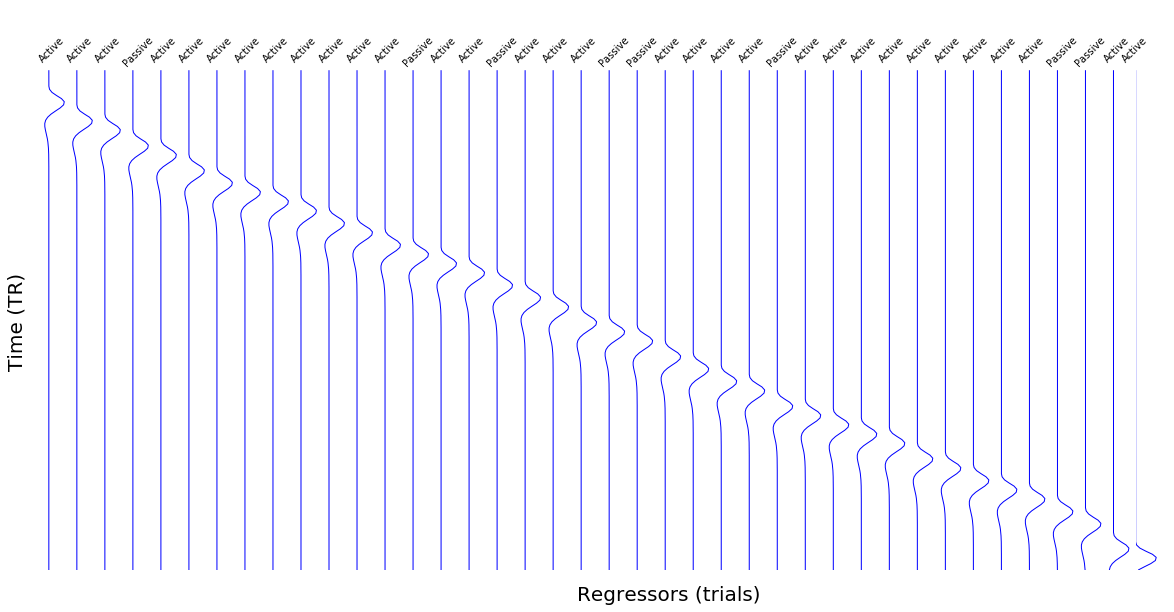

In [6]:
from functions import double_gamma

hrf = double_gamma(range(162))

# List comprehension (fancy for-loop) + stack results back to a matrix
X = np.vstack([np.convolve(hrf, stim_vec[:, i], 'full')[:162] for i in range(40)]).T

plt.figure(figsize=(20, 10))
for plot in range(40):
    plt.subplot(1, 40, plot+1)
    plt.plot(X[:, plot], range(X.shape[0])[::-1])
    plt.axis('off')
    plt.text(-2, 170, 'Active' if onsets[plot, 2] else 'Passive', rotation=45)

plt.text(-60, -10, 'Regressors (trials)', ha='center', fontsize=20)
plt.text(-145, 80, 'Time (TR)', va='center', rotation='vertical', fontsize=20)
plt.show()

We could use this design to extract patterns of $\beta$-values for each regressor. But [it has been shown](http://www.sciencedirect.com/science/article/pii/S1053811910007834) that converting $\beta$-values to *t*-values often creates more stable and robust patterns. $\beta$-values can be normalized to *t*-values by defining a contrast-against-baseline that is subsequently used in the formula for the *t*-value. 

**ik snap deze vraag niet helemaal: hoe heeft het omrekenen van beta's naar t-waardes invloed op je contrast matrix?**

Suppose I want to convert the patterns of $\beta$-values *for each trial* in the design above to *t*-values, what would my contrast-matrix look like? (Hint: check out the first image of this notebook.)

<div class='alert alert-warning'>
**ToDo**: create a design matrix in which each row represents the contrast-against-baseline-vector of a single trial of the within-subject design above. (Hint: check out the `numpy.eye()` function)
</div>

In [7]:
# Example code
np.eye(onsets.shape[0])

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

So, now you know how to create a "single-trial design" for pattern analyses! As a short summary:
- Model each "trial" (or more generally, "instance") as a separate HRF-convolved regressor;
- Additionally define a contrast-matrix in which each trial is contrasted against baseline in order to create *t*-value/*z*-value patterns;

<div class='alert alert-warning'>
**ToDo**: We ran the first-level analysis of the single-trial working-memory design outlined above for fifteen subjects using FSL. You can find the results in the directory: `data/{subject_number}/wm.feat`. Pick one of the subjects, and check out the `stats` subdirectory. You will see forty tstat-niftis, each containing a whole-brain pattern of *t*-stats of a single trial. These contain the data we will use in this tutorial for MVPA.
</div>

Alright, you now know what a single-trial (within-subject) design looks like and what it produces (i.e. single-trial pattern estimates in the form of whole-brain $\beta$/*t*-stat/*z*-stat maps). Before we go on to between-subject designs, we will show what a pattern of a single trial looks like in fslview. This will hopefully give you some more "intuition" on what is meant with a single trial pattern. 

<div class='alert alert-warning'>
**If you have FSL installed on your computer, you can do this yourself!** open up a new terminal or terminal-tab and start fslview (by typing `fslview` in the terminal). Now, click "File" > "Open", navigate to `data/pi0031/wm.feat/stats` and select `tstat1.nii.gz`. Now, to visualize the patterns somewhat more intuitively, set in the fslview header "Min" to 0 and "Max" to 5. Then, click the little circle with the blue "i": <img src="viz.png">
<br>
Under the "lookup table options", select the "Red-Yellow" colormap. What you visualize here are all the voxels that activate during this particular trial. However, a pattern is not necessarily only the voxels that *activate*, but also those that *deactivate*. A pattern is *any* estimated response of the brain during an instance of a sample (here: a trial). Therefore, let's also visualize the deactivating voxels. To do so, click "File" > "Add" and select the `tstat1.nii.gz` image *again*, but now set "Min" to 0 and "Max" to -5. For this file, select the colormap "Blue-Lightblue". 

What you should see now is something like this: <img src="screenshot_within.png">

<br>
What we visualized here is an example of a within-subject pattern of a particular trial ("sample"), in which the activated voxels (relative to baseline) are colored red/yellow, and the deactivated voxels (relative to baseline) are colored blue/lightblue. Make sure you understand how this image represents the pattern of a single sample.
</div>

### 1.3 Data representation
In pattern analyses, there is a specific way to 'store' and represent brain patterns: as 2D matrices of shape N-samples \* N-voxels. **Important**: often (and confusingly), people refer to voxels as (brain) 'features' in pattern analyses. So in articles people often refer to samples-by-features matrices!

Anyway, this is what such a matrix looks like: 
![](data_representation.png)

Each row thus represents the voxel pattern of a sample (or: "instance")!

As you can see, the originally 3D voxel patterns (e.g. whole-brain patterns of *t*-values) are flattened (also called "vectorized" or "raveled") such that we can stack all patterns vertically into a 2D matrix. There are two reasons why pattern analyses need this 2D format and thus discard spatial information about the voxel patterns:
 
1. There are very few analyses that take spatial information into account in the first place (so by flattening we get rid of the spatial information); 
2. Most algorithms used "under the hood" by pattern analyses rely heavily on matrix algebra (which operate on 2D matrices by definition).

Anyway, let's look at an example. We're going to work with the working-memory data (as outline in the beginning of the notebook). Suppose we want to investigate whether we can predict whether a trial is passive or active (factor: working memory load) from (whole-brain) voxel patterns. Consequently, this is a **within-subject design**. As such, we model each trial separately by fitting a single-trial design matrix to obtain patterns of *t*-values per trial (similar to the plot just before Section **1.3**). The results are in the directory: `data/pi0031/wm.feat`. Check out the directory (again) and especially the stats-folder. You should see a bunch of nifti-files which contain 3D voxel patterns with "tstat" values (FSL also produces pes [betas], copes, varcopes - we removed these to minimize data size of this tutorial).

For this analysis, we're going to use patterns of *t*-stats (as is generally recommended over $\beta$s).<br>
As you can see, there are 40 nifti-files with *t*-stats; these refer to the 40 trials in the experiment (32 active trials, 8 passive trials)! Given that we need to adhere to the data representation as outlined above, we are in the following situation:

**What we have**: 40 (3D) nifti-files<br>
**What we need**: one 2D numpy array of shape 40 x {whatever amount of voxels there are in those niftis}

Alright, time to learn some Python gems that help us load in and transform those patterns into a usable 2D numpy matrix.

#### 1.3.1 tips & tricks to load and transform (nifti-)files
As a first thing, we need to find all the paths to the *t*-stat nifti-files. Python has a nifty (pun intended) tool called "`glob`" which can find files/directories on disk using [wildcards](https://en.wikipedia.org/wiki/Wildcard_character). It is usually imported as follows:

In [8]:
from glob import glob

`glob`, in Python, is a function that takes a path (as a string) with one or more wildcard characters (such as the `*`) and searches for files/directories on disk that match that. For example, let's try to find all the png-images in the current directory using glob (these are the images that I used inside this notebook). 

In [9]:
my_search_string = '*.png'
png_files = glob(my_search_string)
print(png_files)

['data_representation.png', 'fslview.png', 'obj_class_diff.png', 'pipelinesX.png', 'screenshot_within.png', 'single_trial_design.png', 'sklearn_transformers.png', 'viz.png', 'within_subject_example.png', 'WM_example.png']


As you can see, it returns a list with all the files/directories that matched the search-string. Note that you can also search files outside of the current directory. To do so, we can simply specify the relative or absolute path to it.

<div class='alert alert-warning'>
**ToDo**: Now you have the skills to actually "glob" all the *t*-stats yourself! Use glob to find all the paths to the t-stats and store the results (a list with 40 strings) in a variable called `tstat_paths`.
</div>

In [10]:
# Example answer
tstat_paths = glob('../data/pi0031/wm.feat/stats/*.nii.gz')

**Warning**: `glob` returns unsorted paths (so in seemingly random order). It's better if we sort the paths before loading them in, so the order of the paths is more intuitive (the first file is tstat1, the seconds tstat2, etc.). Python has a builtin function `sorted()`, which takes a list and sorts it alphabetically. The problem, here, is that if we'd use that - i.e. `sorted(tstat_paths)` - it will actually sort the files as: tstat1, tstat10, tstat11, etc. See for yourself: 

In [11]:
print(sorted(tstat_paths))

['../data/pi0031/wm.feat/stats/tstat1.nii.gz', '../data/pi0031/wm.feat/stats/tstat10.nii.gz', '../data/pi0031/wm.feat/stats/tstat11.nii.gz', '../data/pi0031/wm.feat/stats/tstat12.nii.gz', '../data/pi0031/wm.feat/stats/tstat13.nii.gz', '../data/pi0031/wm.feat/stats/tstat14.nii.gz', '../data/pi0031/wm.feat/stats/tstat15.nii.gz', '../data/pi0031/wm.feat/stats/tstat16.nii.gz', '../data/pi0031/wm.feat/stats/tstat17.nii.gz', '../data/pi0031/wm.feat/stats/tstat18.nii.gz', '../data/pi0031/wm.feat/stats/tstat19.nii.gz', '../data/pi0031/wm.feat/stats/tstat2.nii.gz', '../data/pi0031/wm.feat/stats/tstat20.nii.gz', '../data/pi0031/wm.feat/stats/tstat21.nii.gz', '../data/pi0031/wm.feat/stats/tstat22.nii.gz', '../data/pi0031/wm.feat/stats/tstat23.nii.gz', '../data/pi0031/wm.feat/stats/tstat24.nii.gz', '../data/pi0031/wm.feat/stats/tstat25.nii.gz', '../data/pi0031/wm.feat/stats/tstat26.nii.gz', '../data/pi0031/wm.feat/stats/tstat27.nii.gz', '../data/pi0031/wm.feat/stats/tstat28.nii.gz', '../data/pi003

To fix this issue, we wrote a little function (`sort_nifti_paths()`) that sorts the paths correctly. (If you're interested in how it works, check out the functions.py file.)

In [12]:
# Let's fix it
from functions import sort_nifti_paths
tstat_paths = sort_nifti_paths(tstat_paths)

Now, we have the paths to all the nifti-files of a single subject. To load a nifti-file into a numpy-array in Python, we can use the nibabel package. This package has two useful methods you can use to load your data: `load` and `get_data`. You need to use them consecutively to load the *t*-values. For example, to load the whole-brain pattern of *t*-values of the first trial of subject pi0031:

In [13]:
import nibabel as nib
data = nib.load('../data/pi0031/wm.feat/stats/tstat1.nii.gz').get_data()

<div class='alert alert-warning'>
**ToDo**: in the code block below, write a loop that loads in the tstat nifti-files one by one (using nibabel) and store them in the already preallocated array "X". Note that "X" is a 2D matrix (samples-by-features), but each tstat-file contains a 3D array, so you need to "flatten" the 3D array to a single vector: use e.g. the numpy function "flatten()" or "ravel()". 
</div>

In [14]:
voxel_dims = (80, 80, 37) # The data is in EPI-space
X = np.zeros((len(tstat_paths), np.prod(voxel_dims)))

# Example answer
for trial, tstat_path in enumerate(tstat_paths):
    data = nib.load(tstat_path).get_data()
    data = data.ravel()
    X[trial,:] = data

In [15]:
# Can we check if X is correct here? Would be a good check before continuing to part 2

In [16]:
# Include skbold MVP here?

#### You've reached a milestone!
Starting with raw fMRI data, you now have patterns in the right format (a 2D-matrix of N-samples x N-features). Now, let's start talking about multivariate pattern analyses!

## Part 2. Multivoxel pattern analysis
In Part 1, we discussed within-subject single-trial designs, and showed how to load single-trial data in the right format to perform MVPA. It's now time to actually implement pattern analyses!

We'll be looking at the implementation of concepts like K-fold cross-validation, feature-selection/extraction, model fitting/prediction, permutation testing, and feature visualization. To do so, we'll use the [`scikit-learn`](http://scikit-learn.org) machine learning package in Python (the de-facto and most-used ML package in Python).

Remember that, very generally, MVPA is all about inferring a feature-of-interest (dependent variable) using patterns of fMRI data. Let's call the feature-of-interest **y**, and the patterns of fMRI data **X**. This inference from X to y is called *decoding*: we want to *decode* a dependent variable y from X.

In our case, let's continue with the data from the working memory experiment used in Part 1. Remember that, in this experiment, participants performed two types of trials: "ACTIVE" trials, in which they had to remember the orientation of eight bars, and "PASSIVE" trials in which they did not do anything (note that the screen shortly flickered in the "PASSIVE" trials in order to activate the visual cortex). Let's try to decode trial type from the patterns of *t*-values you creates in Part 1!

### 2.1 Adding the dependent variable y
In Section 1.3, you ended with a nice 2D-matrix of N-samples x N-features. This 2D-matrix contains all whole-brain patterns of *t*-values for all trials: this is your **X**. However, this leaves out a crucial part of the data: the actual feature-of-interest, *trial type*, your **y**.

While there is kind of a generic way to load in voxel patterns, there is usually not a single way to load in your dependent variable (y), because the exact factor that represents `y` dependent on your exact research question (and also depends how you have stored this data on disk). 

In within-subject single-trial designs, trial type or condition is often the dependent variable. The dependent variable can thus be extracted from your design. In fact, we already loaded the dependent variable previously, in the `onsets` variable (see Section 1.2). The third column contains the trial types, where 1 is an "ACTIVE" trial and 0 a "PASSIVE" trial.

## print(onsets)

<div class='alert alert-warning'>
**ToDo**: Extract vector *y* from `onsets`, which only contains the trial types (i.e., y = [1, 1, 1, 0, ..., 0, 1, 1]) 
</div>

In [18]:
# Answer
y = onsets[:,2]

### 2.2 What's next ...
Awesome, we now have everything we need (X and y). This took a while, but you'll soon see it was worth the effort.

In the rest of the tutorial, you'll finally learn how to actually implement decoding pipelines. Typical pipelines consist of the following elements:

* Data partitioning
* Feature selection/extraction
* Model fitting (on train-set)
* Model cross-validation (on test-set)
* Calculate model performance
* Statistical analyses of performance
* Optional: feature visualization 

In the rest of the tutorial, we'll discuss these topics in a slightly different order. First, we'll discuss how you can fit and cross-validate scikit-learn models, and while we're at it, how to calculate model performance (here: accuracy). Subsequently, you'll learn how to embed these concepts in fully cross-validated K-fold data partitioning schemes. Finally, we'll extend our pipelines with feature selection methods. 

### 2.3. Model fitting & cross-validation
First, we'll show you how to use scikit-learn models. In fact, the most useful functionality of scikit-learn is probably that they made fitting and cross-validating models (or, in scikit-learn lingo: estimators) trivially easy. 

Note that in the upcoming example, we will fit the model on *all* our samples. In practice, this is something you would *never* do: you always need to cross-validate your model to a new, independent sample (i.e., independent with respect to noise: the noise in your *training* sample should not be correlated with the noise in your *test* set).

Anyway, let's import a scikit-learn model: the (linear) support vector classifier ([SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), which is one of the most-often used models in fMRI pattern analyses. In scikit-learn, this model is part of the (suprising...) `svm` module:

In [19]:
# Scikit-learn is always imported as 'sklearn'
from sklearn.svm import SVC

Like most of scikit-learn's functionality, SVC is a *class*. Let's initialize an SVC-object! One important argument that this object needs is the ["kernel"](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html) you want the model to have. Basically, the kernel determines how to treat/process your features: linearly, or non-linearly (such as the `kernel='rbf'` or `kernel='poly'` options). Most often a linear kernel is the best option (as non-linear kernels seem to overfit very quickly).

To initialize an SVC-object with a linear kernel, just do as follows:

In [20]:
# clf = CLassiFier
clf = SVC(kernel='linear')

Alright, we initialized an SVC-object with a linear kernel. Now, you need to do two thing to get the prediction for each sample (i.e. whether they're predicted as 0 or 1): fit, using the method `fit(X, y)`, and predict the class (i.e. 0 or 1) for each class using the method `predict(X)`. Basically, in the `fit` method, the parameters of the model (i.e. $\beta$) are estimated. Then, in the `predict` method, the estimated parameters are used to generate a prediction for each sample (i.e. 0 or 1). 

Let's first look at the `fit` method. As you can see, the `fit(X, y)` method with two parameters: X (a samples-by-features matrix) and y (a vector of length n-samples). Let's do that for our data: 

In [21]:
clf.fit(X, y)
print('Fitted SVC...')

Fitted SVC...


After calling the fit() method, the clf-object contains an attribute `coef_` that represent the model's parameters ('coefficients' in scikit-learn lingo, i.e. $\beta$). Let's check that out:

In [22]:
coefs = clf.coef_
print("Shape of coefficients: %r" % (coefs.shape,))

Shape of coefficients: (1, 236800)


Ah, just like we expected: the `coef_` attribute is exactly the same size as the number of voxels in our X-matrix (i.e. 80\*80\*37). 

Anyway, usually, you don't do anything directly with the weights (perhaps only if you want to do anything with feature visualization): scikit-learn handles that for you. What you *do* want, is an actual prediction ($\hat{y}$) for our samples!

To get this, simply call the `predict(X)` method of the model, which returns the predictions as an array:

In [23]:
y_hat = clf.predict(X)
print("The predictions for my samples are:\n %r" % y_hat)

The predictions for my samples are:
 array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1])


A logical next step is to assess how good the model was in predicting the class of the samples. A straightforward metric\* to summarize performance is *accuracy* which can be defined as: 

\begin{align}
accuracy = \frac{number\ of\ correct\ predictions}{number\ of\ predictions}
\end{align}

---------------
\* There are waaaay [more metrics to summarize model performance](http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for classification models, such as precision, recall, F1-score, and ROC-AUC. These metrics are more appropriate than accuracy when you have *imbalanced classes*, i.e. more samples in one class (e.g. negative images) than in another class (e.g. positive images). Usually, however, experimental designs in fMRI pattern analyses are (more of less) balanced, so often you can just use accuracy. 

<div class='alert alert-warning'>
**ToDo**: Can you calculate the accuracy of the above model? Hint 1: you need to compare the true labels (i.e. mvp.y) with the predicted labels (i.e. y_hat). Hint 2: if you do arithmetic with boolean values (i.e. `True` and `False`), `True` is interpreted as 1 and `False` is interpreted as 0.
</div>

In [24]:
# Implement your to-do here!
accuracy = np.sum(y_hat==y) / len(y_hat)
print(accuracy)

1.0


If you've done the ToDo above correctly, you should have found out that the accuracy was 1.0 - a perfect score! "Awesome! Nature Neuroscience material!", you might think. But, as is almost always the case: if it's too good to be true, it probably *is* indeed too good to be true.

So, what is the issue here? Well, we didn't cross-validate the model! We fitted it on all the samples in the mvp-object and predicted the *same* samples, which leads to optimistic estimate of model performance. Such optimistic estimates in uncross-validated models are especially likely when there are many more features (here: voxels) than samples (here: subjects). In other words, we are probably *overfitting* the model here.

Thus, let's check what happens if we actually cross-validate the model. To do so, we need to partition the data into a train- and test-set. For this example, we'll use a simple hold-out scheme, in which we'll reserve half of the data for the test-set (we'll discuss more intricate cross-validation schemes such as K-fold in the next section).

Below, we index `X` and `y` such that the train-set will contain all odd-numbered samples and the test-set will contain all even-number samples:

In [25]:
X_train = X[1::2]
print("Shape X_train: %r" % (X_train.shape,))

y_train = y[1::2]
print("Shape y_train: %r" % (y_train.shape,))

X_test = X[0::2]
print("Shape X_test: %r" % (X_test.shape,))

y_test = y[0::2]
print("Shape y_test: %r" % (y_test.shape,))

Shape X_train: (20, 236800)
Shape y_train: (20,)
Shape X_test: (20, 236800)
Shape y_test: (20,)


<div class='alert alert-warning'>
**ToDo**: now it's up to you to actually implement the *cross-validated* equivalent of the fit/predict procedure we showed you before. So, fit your model on `X_train` and `y_train` and then predict `X_test`. Calculate the cross-validated accuracy by comparing the predictions with `y_test`. 
</div>

In [26]:
# Implement your ToDo here

# Example answer
mod = clf.fit(X=X_train, y=y_train)
y_test_hat = clf.predict(X=X_test)
accuracy = np.sum(y_test_hat==y_test) / len(y_test)
print(accuracy)

0.8


Sweet! You actually performed your first proper decoding analysis in the ToDo above! There are however a couple of things we can do to improve the efficiency and results. One thing we can do is to use the data more efficiently in cross-validation. In the previous example, we split the data into two sets and fit the model on one (the train-set) and cross-validated to the other (the test-set). There is actually a way to "re-used" the data by using K-fold cross-validation, in which data is iteratively partitioned in train- and test-sets. This is explained in the next section.

### 2.4 Data partitioning: K-fold cross-validation
There are two principled ways of cross-validation: 

* Hold-out cross-validation;
* K-fold cross-validation;

In the previous section we implemented a form of hold-out cross-validation, which can be seen as a kind of "one-shot cross-validation". In fMRI data-sets, however, we usually have few samples (simply because MRI-data is expensive to acquire!). Because K-fold cross-validation allows you to reuse the data, it is much more common than hold-out cross-validation in MRI studies.

Now, we can finally use some of scikit-learn's functionality. We are going to use the [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) object from scikit-learn's model_selection module. Click the highlighted link above and read through the manual to see how it works.

Importantly, if you're dealing with a classification analysis, always use *Stratified*KFold (instead of the regular [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), because this version makes sure that each fold contains the same proportion of the different classes (here: 0 and 1). Anyway, enough talking. Let's initialize a StratifiedKFold object with 5 folds:

In [27]:
# scikit-learn is imported as 'sklearn'
from sklearn.model_selection import StratifiedKFold

# They call folds 'splits' in scikit-learn
skf = StratifiedKFold(n_splits=5)

Alright, we have a StratifiedKFold object now, but not yet any indices for our folds (i.e. indices to split X and y into different samples). To do that, we need to call the `split(X, y)` method:

In [28]:
folds = skf.split(X, y)

Now, we created the variable `folds` which is officially a [generator](https://wiki.python.org/moin/Generators) object, but just think of it as a type of list (with indices) which is specialized for looping over it. Each entry in `folds` is a tuple with two elements: an array with train-indices and an array with test-indices. Let's demonstrate that\*:

-------------
\* Note that you can only run the cell below once. After running it, the `folds` generator object is "exhausted", and you'll need to call `skf.split(mvp.X, mvp.y)` again in the above cell.

In [29]:
i = 1
for fold in folds:
    
    print("Processing fold %i" % i)
    # Here, we unpack fold (a tuple) to get the train- and test-indices
    train_idx = fold[0]
    test_idx = fold[1]
    
    print("Train-indices: %s" % train_idx)
    print("Test-indices: %s\n" % test_idx)
    
    i += 1
i = 0

Processing fold 1
Train-indices: [ 8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
Test-indices: [ 0  1  2  3  4  5  6  7 13]

Processing fold 2
Train-indices: [ 0  1  2  3  4  5  6  7 13 17 18 19 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39]
Test-indices: [ 8  9 10 11 12 14 15 16 20]

Processing fold 3
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 20 25 27 28 29 30 31 32
 33 34 35 36 37 38 39]
Test-indices: [17 18 19 21 22 23 24 26]

Processing fold 4
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 32 33 34 35 37 38 39]
Test-indices: [25 27 28 29 30 31 36]

Processing fold 5
Train-indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 36]
Test-indices: [32 33 34 35 37 38 39]



As you can see, StratifiedKFold determined that for the first fold, sample 1 to 9 should be used for training and sample 0 and 2 (remember, Python uses 0-based indexing!) should be used for testing.

Now, we know how to access the train- and test-indices, but we haven't *actually* indexed our X and y (i.e. mvp.X and mvp.y) in the for-loop over folds. Nor have we actually fit the model on the train-set and cross-validated this to the test-set.

<div class='alert alert-warning'>
**ToDo**: in the code-cell below, complete the statements by indexing X and y to create four different objects in every fold: X_train, y_train, X_test, y_test. Also, we created a new classifier-object (clf) for you based on a different model: scikit-learn's `LogisticRegression` to show you that *every* model in scikit-learn works the same. Use this classifier to fit on the train-set and predict the test-set in every fold. Then, calculate the (cross-validated) accuracy in every fold. Keep track of the accuracies across folds, and after the loop over folds, calculate the average accuracy across folds.
</div>

In [30]:
from sklearn.linear_model import LogisticRegression

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(X, y)

accuracy = []

for fold in folds:
    
    # This is a slightly more concise way to unpack tuples
    train_idx, test_idx = fold
    
    # Complete these statements by indexing X and y with train_idx and test_idx
    X_train = 
    y_train = 
    
    X_test = 
    y_test = 
    
    # ToDo: call fit (on train) and predict (on test)
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


SyntaxError: invalid syntax (<ipython-input-30-363bf77f3765>, line 16)

In [31]:
# EXAMPLE AMSWER
from sklearn.linear_model import LogisticRegression

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(X, y)

accuracy = []

for fold in folds:
    
    # This is a slightly more concise way to unpack tuples
    train_idx, test_idx = fold
    
    # Complete these statements by indexing X and y with train_idx and test_idx
    X_train = X[train_idx,:]
    y_train = y[train_idx]
    
    X_test = X[test_idx,:]
    y_test = y[test_idx]
    
    # ToDo: call fit (on train) and predict (on test)
    model = clf.fit(X=X_train, y=y_train)
    y_hat = model.predict(X=X_test)
    
    # ToDo: calculate accuracy
    accuracy.append(np.sum(y_hat==y_test)/len(y_test))

# ToDo: calculate average accuracy
print('Mean accuracy: %.3f' % np.mean(accuracy))

Mean accuracy: 0.810


Implementing K-fold cross-validation instead of hold-out cross-validation allowed us to make our analysis a little more efficient (by reusing samples). Another method that (usually) improves performance in decoding analyses is feature selection/extraction. 

## 2.5. Feature selection/extraction
As discussed before, a small sample/feature-ratio often results in overfitting (optimistic performance estimates on train-set). It follows then that reducing the amount of features often has a beneficial effect on cross-validated performance estimates.

Feature reduction can be achieved in two principled ways:

* feature extraction: transform your features into a set of lower-dimensional components;
* feature selection: select a subset of features

Examples of feature extraction are PCA (i.e. transform voxels to orthogonal components) and averaging features within brain regions from an atlas. Because feature extraction often does not use any information from the labels (`y`), this step does not need to be cross-validated (but you *can* cross-validate, e.g., PCA by estimating the components on the train-set only). 

Examples of feature selection are ROI-analysis (i.e. restricting your patterns to a specific ROI in the brain) and "univariate feature selection" (UFS). This latter method is an often-used data-driven method to select features based upon their univariate difference. 

Fortunately, scikit-learn has a bunch of feature selection/extraction objects for us to use. These objects ("transformers" in scikit-learn lingo) work similarly to estimators: they also have a `fit(X, y)` method, in which for example the univariate differences (in UFS) or PCA-components (in PCA-driven feature extraction) are computed. Then, instead of having a `predict(X)` method, transformers have a `transform(X)` method.

### 2.5.1. (Univariate) feature selection
As an example of feature selection, let's take a closer look at how UFS can be implemented using scikit-learn. Basically, it follows the following structure:

`transformer = Selector(score_func=ufs_function, other_args)`

Here, the `score_func` parameter takes a function that implements a univariate statistical test (like an [f-test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) or a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.chi2)). The `Selector` class determines how to select the subset of features based on the result of the `score_func`. 

For example, the [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) selector selects the best `K` features based on their scores from the statistical test. For example, the following transformer would select the best 100 features based on their F-score:

In [32]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif is a scikit-learn specific implementation of the F-test
select100best = SelectKBest(score_func=f_classif, k=100)

Another example of a selector is `SelectFwe` which selects only features with statistics-values corresponding to p-values lower than a set alpha-level. For example, the following transformer would only select features with p-values from a chi-square test lower than 0.01: 

In [33]:
from sklearn.feature_selection import SelectFwe, chi2
selectfwe_transformer = SelectFwe(score_func=chi2, alpha=0.01)

<div class='alert alert-info'>
**ToThink**: The functions `f_classif` and `chi2` are functions to calculate statistics for when the the DV is categorical (i.e. in classification scenarios). Can you think of a function that does the same when your DV is continuous (i.e. in regression scenarios)? 
</div>

But how does this work in practice? We'll show you an (not cross-validated!) example using the select100best transformer initialized earlier:

In [34]:
# Fit the transformer ...
select100best.fit(X, y)

# ... which calculates the following attributes (.scores_ and .pvalues_)
# Let's check them out
scores, pvalues = select100best.scores_, select100best.pvalues_

# As you can see, each voxel gets its own score (in this case: an F-score)
print(scores.size)

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


236800


We can also visualize these scores in brain space (it's a coronal slice sideways ...): 

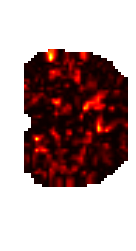

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

scores_3d = scores.reshape((80, 80, 37))
plt.imshow(scores_3d[:, 45, :], origin='lower', cmap='hot')
plt.axis('off')
plt.show()

Thus, in the image above, brighter (more yellow) colors represent voxels with higher scores on the univariate test. If we subsequently apply (or "transform" in scikit-learn lingo) our X-matrix using, for example, the `select100best` selector, we'll select only the 100 "most yellow" (i.e. highest F-scores) voxels.

<div class='alert alert-info'>
**ToThink**: Given the image above, what is the major difference between data driven feature selection (like UFS) and ROI-based feature selection (e.g. only look at patterns in the amygdala) in terms of the spatial scale of patterns you'll select? Try to think of an example of UFS over ROI-based feature selection and vice versa.
</div>

Practically, after we've fit the transformer, we can call the `transform(X)` method that will actually select the subset according to the selector:

In [44]:
print("Shape of mvp.X before transform: %r ..." % (X.shape,))
X_after_ufs = select100best.transform(X)

print("... and shape of mvp.X after transform: %r." % (X_after_ufs.shape,))

Shape of mvp.X before transform: (40, 236800) ...
... and shape of mvp.X after transform: (40, 100).


As you can see, the transformer correctly selected a subset of 100 voxels from our X matrix! Now, both selectors were fit on the entire dataset, which is often course not how it should be done: because they use information from the labels (`y`), this step should be cross-validated. Thus, what you have to do is:

* fit your transformer on the train-set;
* transform your train-set;
* transform your test-set;
* (fit your model on the train-set;)
* (cross-validate to the test-set;)

We summarized the entire pipeline, including data partitioning (indexing), feature selection (transformation), and model fitting and their corresponding cross-validation steps in the image below:
<img src='sklearn_transformers.png'>

### 2.5.2 Feature extraction
There are many methods for feature extraction, like "downsampling" to ROI-averages (i.e. averaging voxel patterns in brain regions) and dimensionality-reduction techniques like PCA. Scikit-learn provides some of these techniques as "transformer" objects, which again have a `fit()` and `transform` method. In the next ToDo, you'll apply this!

<div class='alert alert-warning'>
**ToDo**: Below, we import the `PCA` class from scikit-learn. Check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Now, initialize an object from this `PCA`-class with the number of components to store set to 5, and subsequently fit in on `X` and subsequently call transform on `X` (note that you do not have to cross-validate this procedure!) and store the result in a new variable named `X_pca_transformed`. Then, check out the shape of `X_pca_transformed`: does this make sense?
</div>

In [ ]:
from sklearn.decomposition import PCA

# initialize a PCA object ...

# ... call fit on X ...


# ... and call transform on X
X_pca_transformed = 

# And finally check out the shape of X_pca_transformed!


In [50]:
from sklearn.decomposition import PCA

# initialize a PCA object ...
pca = PCA()

# ... call fit on X ...
pca.fit(X=X)

# ... and call transform on X
X_pca_transformed = pca.transform(X)

# And finally check out the shape of X_pca_transformed!
X_pca_transformed.shape

(40, 40)

Now, let's put everything you learned so far together and implement a fully cross-validated pipeline with UFS *and* model fitting/prediction!

<div class='alert alert-warning'>
**ToDo**: Below, we set up a K-fold cross-validation loop and prespecified a classifier (`clf`, a logistic regression model) and a transformer (`select50best`, selecting the 50 best features based upon an F-test). Now, it's up to you to actually implement the feature selection inside the for-loop. Make sure to fit the transformer only on the train-set, but then transform *both* the train-set and the test-set. Then, fit the model on the transformed train-set and cross-validate to the transformed test-set. Calculate accuracy of the cross-validated  model for each fold, and after all folds calculate the average accuracy (across folds).
</div>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(X, y)

accuracy = []

select50best = SelectKBest(score_func=f_classif, k=50)

for fold in folds:
    
    train_idx, test_idx = fold
    
    # ToDo: make X_train, X_test, y_train, y_test
    
    # ToDo: call the select50best fit method (on train) and predict (on test)
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


In [52]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(X, y)

accuracy = []

select50best = SelectKBest(score_func=f_classif, k=50)

for fold in folds:
    
    train_idx, test_idx = fold
    
    # ToDo: make X_train, X_test, y_train, y_test
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # ToDo: call the select50best fit method (on train) and predict (on test)
    select50best.fit(X=X_train, y=y_train)
    X_train = select50best.transform(X=X_train)
    X_test = select50best.transform(X=X_test)
    
    # ToDo: calculate accuracy
    clf.fit(X=X_train, y=y_train)
    y_test_hat = clf.predict(X=X_test)
    accuracy.append(np.sum(y_test==y_test_hat)/len(y_test_hat))

# ToDo: calculate average accuracy
print('Mean accuracy: %.3f' % np.mean(accuracy))

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Mean accuracy: 0.807


### Optional: advanced cross-validation using Pipelines
(Recommended, but optional: only go through this section if you have time)

As you have seen in the previous assignment, the code within the K-fold for-loop becomes quite long (and messy) when you add a feature-selection step. Suppose you want to add another feature extraction step, like performing a PCA after an initial feature selection step. The code becomes even more obscure ...

Luckily, scikit-learn has an awesome solution for this: "Pipelines".

Pipelines are somewhat more advanced functionality within scikit-learn, but we wanted to show you guys because it really "cleans up" your code, and additionally, it is a great safeguard for accidental overfitting (e.g. when you accidentally perform feature-selection on all your data instead of only your train-data). 

Anyway, how does this work? Well, a picture it worth a thousand words, so check out the image below which schematically depicts what a pipeline does: <img src='pipelinesX.png'>

As you can see, a `Pipeline`-object "strings together" an arbitrary number of transformers (including "preprocessing" transformers like `StandardScaler`\*) and can optionally end in an estimator. Pipeline-objects have two (relevant) methods: `fit(X, y)` and `predict(X, y)` (the latter method only exists if there is an estimator in the pipeline). To use it, you only have to call `fit()` with `X_train` and `y_train` and it'll sequentially fit the transformers which will finally pass the transformed data to the estimator. Then, simply call `predict()` with `X_test` as argument and the pipeline will automatically cross-validate all fitted transformers, and eventually the estimator, on the `X_test` variable. 

Okay, lot's of info - let's break this down. First, let's initialize some transformers and an estimator:

------------
\* [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) is a scikit-learn transformer that does exactly the same as the `standardize()` method you implemented earlier! Strictly speaking, you don't need to cross-validate your standardization step, but it doesn't hurt either. 

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
ufs = SelectKBest(score_func=f_classif, k=1000)
pca = PCA(n_components=10)  # we want to reduce the features to 10 components
svc = SVC(kernel='linear')

Now, to initialize a Pipeline-object, we need to give it a list of tuples, in the first entry of each tuple is a name for the step in the pipeline and the second entry of each tuple is the actual transformer/estimator object. Let's do that for our pipeline:

In [55]:
from sklearn.pipeline import Pipeline

pipeline_to_make = [('preproc', scaler),
                    ('ufs', ufs),
                    ('pca', pca),
                    ('clf', svc)]

my_pipe = Pipeline(pipeline_to_make)

Let's test our pipeline-object (`my_pipe`) on our data. For this example, we'll use a simple hold-out cross-validation scheme (but pipelines are equally valuable in K-fold CV schemes!).

In [56]:
X_train, y_train = X[0::2], y[0::2]
X_test, y_test = X[1::2], y[1::2]

my_pipe.fit(X_train, y_train)
predictions = my_pipe.predict(X_test)
acc = np.mean(predictions == y_test)
print("Cross-validated accuracy on test-set: %.3f" % acc)

/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [     0      1      2 ..., 236797 236798 236799] are constant.
  UserWarning)
/Users/steven/anaconda/envs/python3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Cross-validated accuracy on test-set: 0.800


Cool stuff huh? Quite efficient, I would say!